<a href="https://colab.research.google.com/github/nlimsupt/credit-card-fraud-detection/blob/main/Copy_of_MIS_637_Group1_Credit_Card_Fraud_Detection_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Data Analytics & Machine Learning Final Project: Credit Card Fraud Detection**

# **Section 1: Problem Definition**

**Research Question**

Can machine learning models effectively identify fraudulent credit card transactions under extreme class imbalance, while maintaining a practical balance between fraud detection and false alerts?

**Motivation and Significance**

Credit card fraud poses significant financial and operational risks for financial institutions. However, fraudulent transactions represent only a very small fraction of all transactions, making fraud detection a challenging classification problem. Traditional accuracy-based evaluation is insufficient in this context, as models may achieve high accuracy by predicting all transactions as legitimate while failing to detect fraud cases.

This project is motivated by the need to design and evaluate classification models that explicitly address class imbalance and focus on metrics that better reflect fraud detection performance.

Effective fraud detection models can help financial institutions reduce financial losses and enhance transaction security. At the same time, excessive false positives may lead to unnecessary transaction blocks and negative customer experience. By prioritizing imbalance-aware evaluation metrics such as recall, F1-score, and PR-AUC, this project aims to support more informed model selection and highlight the trade-off between capturing fraudulent transactions and minimizing false alerts in real-world applications.

# **Section 2: Data Analysis Task and Methodology**

**Data Analysis Task**

This project addresses a binary classification task, where each credit card transaction is classified as either legitimate or fraudulent. The primary analytical challenge lies in the extreme class imbalance, as fraudulent transactions account for only a very small proportion of the dataset.

Given this imbalance, the task requires modeling approaches and evaluation strategies that emphasize minority-class detection rather than overall accuracy.

**Multivariate Techniques**

**1.   Logistic Regression**

• Chosen for interpretability and as a common baseline model due to its interpretability and common use in fraud detection..

**2.   XGBoost**

• Selected to capture complex non-linear relationships among transaction features and to incorporate cost-sensitive learning through class weighting.

• Included as an advanced model to leverage gradient boosting and cost-sensitive learning for improved fraud detection.

**Model Assumptions**

**1.   Assumptions of Logistic Regression**

• Linearity of log-odds: Assumes predictors relate linearly to the log-odds of the outcome. Feature scaling was applied to support numerical stability.

• Independence of observations: Each transaction is treated as an independent observation, which is a common assumption in transaction-level fraud detection.

• No perfect multicollinearity: PCA-transformed features reduce multicollinearity among predictors.

• Sensitivity to class imbalance: Addressed using SMOTE within the training pipeline.

• Sensitive to class imbalance: Addressed using SMOTE within the training pipeline.

**2.   Model Characteristics of XGBoost**

• No strict statistical assumptions: XGBoost does not assume linear relationships or specific data distributions.

• Ability to capture non-linearities: Tree-based boosting enables the model to capture complex non-linear relationships and feature interactions.

• Handling class imbalance: Class imbalance was addressed using cost-sensitive learning through the scale_pos_weight parameter, which assigns higher penalties to misclassified fraudulent transactions.

# **Section 3: Data Description**

**Dataset Source**

The dataset used in this project is the Credit Card Fraud Detection dataset obtained from Kaggle. The data contain credit card transactions made by European cardholders in September 2013 and were collected as part of a research collaboration between Worldline and the Machine Learning Group at Université Libre de Bruxelles (ULB).

The dataset includes 284,807 transactions recorded over a two-day period, among which 492 transactions are fraudulent, resulting in a severe class imbalance where fraud cases account for approximately 0.172% of all observations.

**Variables**

**PCA Components (V1–V28)**
- Transformed using Principal Component Analysis (PCA) due to confidentiality constraints  
- Original transaction features are not available  
- PCA transformation reduces dimensionality and removes identifying information while retaining major variance patterns  
- Most component values are centered around zero

**Time Variable**
- Represents the elapsed time in seconds between each transaction and the first transaction in the dataset

**Amount Variable**
- Represents the transaction amount  
- Can be incorporated into cost-sensitive learning or threshold-based decision strategies

**Class Variable**
- `Class = 1` indicates a fraudulent transaction  
- `Class = 0` indicates a legitimate transaction


In [ ]:
pip install kagglehub

Note: you may need to restart the kernel to use updated packages.


In [ ]:
# import modules
import kagglehub
import pandas as pd
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb
import time
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, confusion_matrix, f1_score, roc_auc_score, classification_report, roc_curve, precision_recall_curve, average_precision_score)
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE


In [ ]:
# Download latest version
path = kagglehub.dataset_download("mlg-ulb/creditcardfraud")

print("Path to dataset files:", path)

csv_path = os.path.join(path, "creditcard.csv")
df = pd.read_csv(csv_path)

df.head()

Path to dataset files: /Users/nlimsupt/.cache/kagglehub/datasets/mlg-ulb/creditcardfraud/versions/3


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
df.info()
print("\nDataset Shape:", df.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [ ]:
df.describe()
# Looking to the Time feature, we can confirm that the data contains 283, 726 transactions, during 2 consecutive days (or 172792 seconds).

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


**Handling Missing Values & Duplications**

No missing values were identified in this dataset. However, a total of 1,081 duplicate records were detected. These observations were retained, as duplicate transactions may represent legitimate repeated activities or meaningful fraud patterns, such as repeated charges, which are relevant in credit card fraud detection tasks.

In [ ]:
df.isna().sum()

,0
Time,0
V1,0
V2,0
V3,0
V4,0
V5,0
V6,0
V7,0
V8,0
V9,0


In [ ]:
df.duplicated().sum()

np.int64(1081)

In [ ]:
# separate X, y for modeling
X = df.drop('Class', axis=1)
y = df['Class']

print(y.value_counts())
print("\nClass proportion (%):")
print(np.round(y.value_counts(normalize=True) * 100, 2))

Class
0    284315
1       492
Name: count, dtype: int64

Class proportion (%):
Class
0    99.83
1     0.17
Name: proportion, dtype: float64


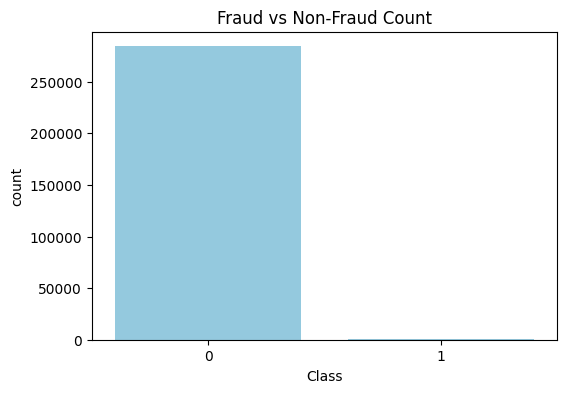

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x='Class', data=df, color="skyblue")
plt.title("Fraud vs Non-Fraud Count")
plt.show()

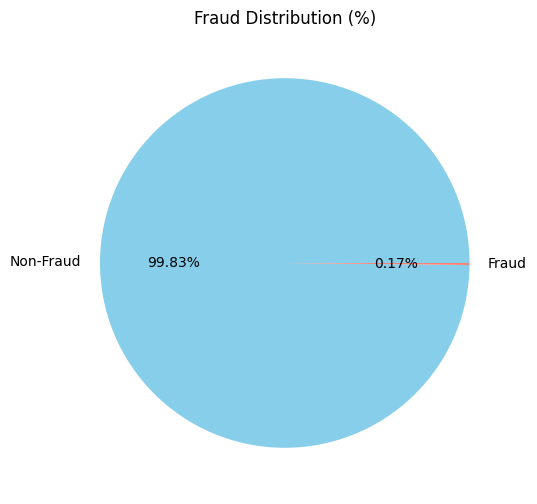

In [ ]:
plt.figure(figsize=(6,6))
colors = ['skyblue', 'salmon']  # Non-Fraud, Fraud
df['Class'].value_counts().plot.pie(
    autopct='%1.2f%%',
    labels=['Non-Fraud', 'Fraud'],
    colors=colors)
plt.title("Fraud Distribution (%)")
plt.ylabel("")
plt.show()

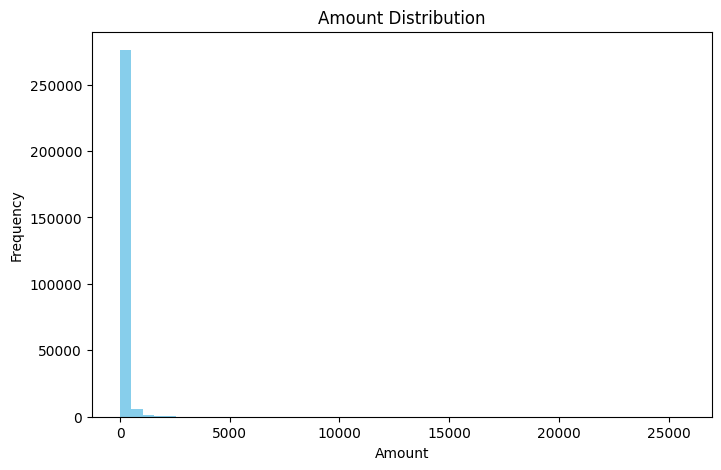

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df["Amount"], bins=50, color="skyblue")
plt.title("Amount Distribution")
plt.xlabel("Amount")
plt.ylabel("Frequency")
plt.show()

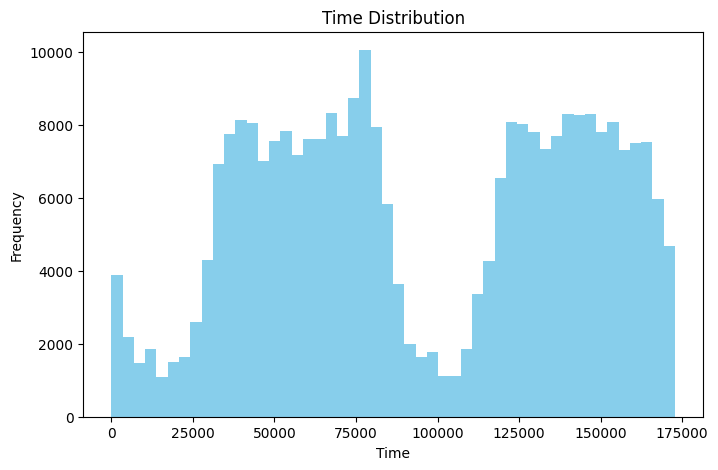

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(df["Time"], bins=50, color="skyblue")
plt.title("Time Distribution")
plt.xlabel("Time")
plt.ylabel("Frequency")
plt.show()

/tmp/ipython-input-1787950363.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==0]["Amount"], shade=True, label="Non-Fraud")
/tmp/ipython-input-1787950363.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==1]["Amount"], shade=True, label="Fraud")


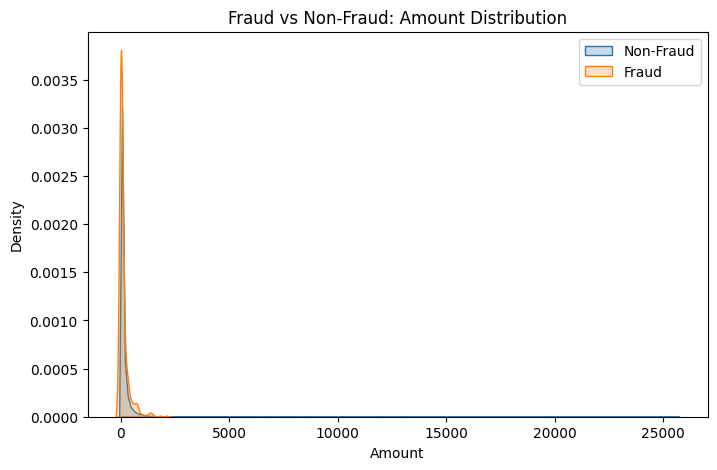

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df["Class"]==0]["Amount"], shade=True, label="Non-Fraud")
sns.kdeplot(df[df["Class"]==1]["Amount"], shade=True, label="Fraud")
plt.title("Fraud vs Non-Fraud: Amount Distribution")
plt.legend()
plt.show()

/tmp/ipython-input-1055324393.py:2: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==0]["Time"], shade=True, label="Non-Fraud")
/tmp/ipython-input-1055324393.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(df[df["Class"]==1]["Time"], shade=True, label="Fraud")


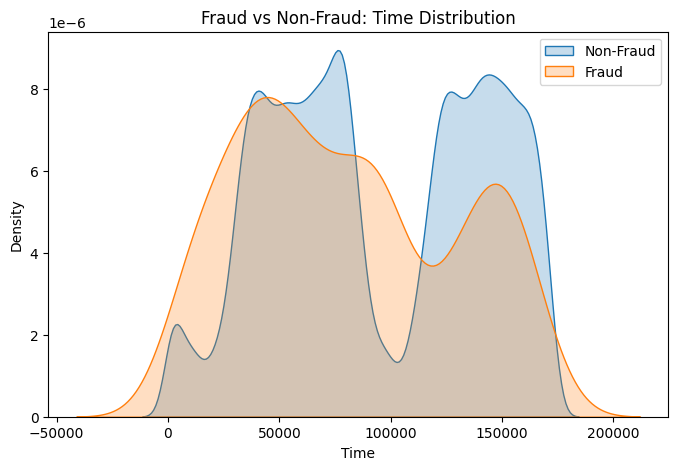

In [ ]:
plt.figure(figsize=(8,5))
sns.kdeplot(df[df["Class"]==0]["Time"], shade=True, label="Non-Fraud")
sns.kdeplot(df[df["Class"]==1]["Time"], shade=True, label="Fraud")
plt.title("Fraud vs Non-Fraud: Time Distribution")
plt.legend()
plt.show()


**EDA Summary**

Exploratory data analysis confirms the extreme class imbalance in the dataset, with fraudulent transactions representing only a very small fraction of all observations. Transaction amounts exhibit a highly skewed distribution, motivating feature scaling prior to model training. While some differences in amount distributions between fraudulent and legitimate transactions are observed, most input features are anonymized PCA components, limiting direct interpretability. These findings motivate the use of imbalance-aware modeling techniques and evaluation metrics in subsequent analysis.

# **Section 4: Analysis and Results**

This section presents and compares the performance of three classification models for credit card fraud detection under extreme class imbalance: Logistic Regression with SMOTE, Random Forest with SMOTE, and XGBoost with scale_pos_weight. Model evaluation focuses on imbalance-aware metrics, particularly Precision, Recall, F1-score, and PR-AUC, rather than overall accuracy.

**Cross-Validation Performance**

Stratified 5-fold cross-validation using PR-AUC as the primary scoring metric was conducted on the training data. The results indicate a clear performance hierarchy among the models. Logistic Regression with SMOTE achieved a mean PR-AUC of approximately 0.76, serving as a strong baseline but exhibiting relatively high variance. Random Forest with SMOTE improved performance substantially, achieving a mean PR-AUC of around 0.84. XGBoost with cost-sensitive learning (scale_pos_weight) achieved the highest mean PR-AUC at approximately 0.85, demonstrating superior ability to rank fraudulent transactions higher than legitimate ones across different thresholds.

**Test Set Evaluation**

On the held-out test set, the models exhibited distinct trade-offs between precision and recall for the fraud class (Class = 1). Logistic Regression with SMOTE achieved high recall (0.88) but relatively low precision (0.57), indicating that while most fraudulent transactions were detected, a large number of false positives were generated. Random Forest with SMOTE improved precision to 0.80 while maintaining the same recall (0.88), resulting in a substantially higher F1-score (0.83) and PR-AUC (0.86).

XGBoost with scale_pos_weight achieved the best overall balance, with the highest precision (0.86) and PR-AUC (0.88), while maintaining a strong recall (0.84). This indicates that XGBoost was more effective at reducing false alarms without excessively sacrificing fraud detection capability. The superior F1-score (0.85) further confirms that XGBoost provides the most favorable trade-off between precision and recall among the evaluated models.

**Confusion Matrix Analysis**

Confusion matrix comparisons further highlight practical differences between models. Logistic Regression produced a relatively large number of false positives, which may negatively impact customer experience in real-world deployment. Random Forest reduced false positives substantially while maintaining a low number of false negatives. XGBoost achieved the lowest number of false positives among the evaluated models, with only a modest increase in false negatives compared to Random Forest. Overall, XGBoost demonstrated the most balanced error profile, making it particularly suitable for fraud detection scenarios where minimizing unnecessary transaction blocks is critical.

In [ ]:
# train-test split (stratified)

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("\nTrain class distribution:\n", y_train.value_counts(normalize=True).round(3))

Train size: (227845, 30)  Test size: (56962, 30)

Train class distribution:
 Class
0    0.998
1    0.002
Name: proportion, dtype: float64


In [ ]:
# scale only Time, Amount
preprocess = ColumnTransformer(
    transformers=[
        ("scale_time_amount", StandardScaler(), ["Time", "Amount"])
    ],
    remainder="passthrough",
    force_int_remainder_cols=False
)

print(X_train.columns[:])

Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount'],
      dtype='object')


In [ ]:
# logistic regression + SMOTE
log_reg_smote = ImbPipeline(steps=[
    ("preprocess", preprocess),
    ("smote", SMOTE(sampling_strategy=0.05, random_state=42)),
    ("logreg", LogisticRegression(
        max_iter=300,
        solver="liblinear",
        class_weight=None,
        penalty="l2",
        C=1.0,
        random_state=42
    ))
])

# CV settings (Fraud: PR-AUC is more informative)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prefer PR-AUC for imbalanced classification
pr_auc_scores = cross_val_score(
    log_reg_smote,
    X_train,
    y_train,
    cv=cv,
    scoring='average_precision'
)

print("\n===== Stratified 5-fold CV (LogReg + SMOTE) =====")
print("PR-AUC per fold:", np.round(pr_auc_scores, 4))
print("Mean PR-AUC:", pr_auc_scores.mean().round(4),
      " Std:", pr_auc_scores.std().round(4))

# Fit final pipeline on full training set
log_reg_smote.fit(X_train, y_train)


===== Stratified 5-fold CV (LogReg + SMOTE) =====
PR-AUC per fold: [0.8112 0.7621 0.6971 0.8056 0.7377]
Mean PR-AUC: 0.7628  Std: 0.0427


Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scale_time_amount',
                                                  StandardScaler(),
                                                  ['Time', 'Amount'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.05)),
                ('logreg',
                 LogisticRegression(max_iter=300, random_state=42,
                                    solver='liblinear'))])

In [ ]:
# logistic regression (SMOTE) train accuracy
y_pred_train_log_smote = log_reg_smote.predict(X_train)

train_acc_log_smote = accuracy_score(y_train, y_pred_train_log_smote)
print(f"Logistic Regression (with SMOTE) Train Accuracy: {train_acc_log_smote:.4f}")

# logistic regression (SMOTE) test accuracy
y_pred_test_log_smote = log_reg_smote.predict(X_test)

test_acc_log_smote = accuracy_score(y_test, y_pred_log_smote)
conf_matrix_log = confusion_matrix(y_test, y_pred_log_smote)

print(f"\nLogistic Regression (with SMOTE) Test Accuracy: {test_acc_log_smote:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_log)

Logistic Regression (with SMOTE) Train Accuracy: 0.9988

Logistic Regression (with SMOTE) Test Accuracy: 0.9987

Confusion Matrix:
[[56800    64]
 [   12    86]]


In [ ]:
# random forest + SMOTE
rfc_smote = ImbPipeline(steps=[
    ('preprocess', preprocess),
    ('smote', SMOTE(sampling_strategy=0.05, random_state=42)),
    ('rf', RandomForestClassifier(
        n_estimators=300,
        class_weight=None,
        max_depth=8,
        min_samples_split=10,
        min_samples_leaf=4,
        random_state=42,
        n_jobs=-1
    ))
])

# CV settings (Fraud: PR-AUC is more informative)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Prefer PR-AUC for imbalanced classification
pr_auc_scores = cross_val_score(
    rfc_smote,
    X_train,
    y_train,
    cv=cv,
    scoring='average_precision'
)

print("\n===== Stratified 5-fold CV (RF + SMOTE) =====")
print("PR-AUC per fold:", np.round(pr_auc_scores, 4))
print("Mean PR-AUC:", pr_auc_scores.mean().round(4),
      " Std:", pr_auc_scores.std().round(4))

# fit pipeline on training set
rfc_smote.fit(X_train, y_train)


===== Stratified 5-fold CV (RF + SMOTE) =====
PR-AUC per fold: [0.855  0.8141 0.8167 0.8814 0.8285]
Mean PR-AUC: 0.8391  Std: 0.0256


Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scale_time_amount',
                                                  StandardScaler(),
                                                  ['Time', 'Amount'])])),
                ('smote', SMOTE(random_state=42, sampling_strategy=0.05)),
                ('rf',
                 RandomForestClassifier(max_depth=8, min_samples_leaf=4,
                                        min_samples_split=10, n_estimators=300,
                                        n_jobs=-1, random_state=42))])

In [ ]:
# random forest (with SMOTE) train accuracy
y_pred_train_rf_smote = rfc_smote.predict(X_train)

train_acc_rf_smote = accuracy_score(y_train, y_pred_train_rf_smote)
print(f"Random Forest (with SMOTE) - Train Accuracy: {train_acc_rf_smote:.4f}")

# random forest (with SMOTE) test accuracy
y_pred_test_rf_smote = rfc_smote.predict(X_test)

test_acc_rf_smote = accuracy_score(y_test, y_pred_test_rf_smote)
conf_matrix_rf_smote = confusion_matrix(y_test, y_pred_test_rf_smote)

print(f"\nRandom Forest (with SMOTE) - Test Accuracy: {test_acc_rf_smote:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_rf_smote)

Random Forest (with SMOTE) - Train Accuracy: 0.9995

Random Forest (with SMOTE) - Test Accuracy: 0.9994

Confusion Matrix:
[[56842    22]
 [   12    86]]


In [ ]:
# XGBoost + scale_pos_weight
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
print("scale_pos_weight:", scale_pos_weight)

xgb_weighted = Pipeline(steps=[
    ("preprocess", preprocess),
    ("xgb", xgb.XGBClassifier(
        objective="binary:logistic",
        n_estimators=800,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        reg_alpha=0.0,
        scale_pos_weight=scale_pos_weight,
        eval_metric="aucpr",
        random_state=42,
        n_jobs=-1
    ))
])

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

pr_auc_scores = cross_val_score(
    xgb_weighted,
    X_train,
    y_train,
    cv=cv,
    scoring="average_precision"
)

print("\n===== Stratified 5-fold CV (XGBoost + scale_pos_weight) =====")
print("PR-AUC per fold:", np.round(pr_auc_scores, 4))
print("Mean PR-AUC:", pr_auc_scores.mean().round(4),
      " Std:", pr_auc_scores.std().round(4))

# fit final model on full training set
xgb_weighted.fit(X_train, y_train)

scale_pos_weight: 577.2868020304569

===== Stratified 5-fold CV (XGBoost + scale_pos_weight) =====
PR-AUC per fold: [0.8589 0.8279 0.8401 0.8913 0.8509]
Mean PR-AUC: 0.8538  Std: 0.0215


Pipeline(steps=[('preprocess',
                 ColumnTransformer(force_int_remainder_cols=False,
                                   remainder='passthrough',
                                   transformers=[('scale_time_amount',
                                                  StandardScaler(),
                                                  ['Time', 'Amount'])])),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=0.9, device=None,
                               early_stopping_rounds=None,
                               ena...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.05,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=5, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=800, n_jobs=-1,
                               num_parallel_tree=None, ...))])

In [ ]:
# XGBoost (with scale_pos_weight) train accuracy
y_pred_train_xgb_weighted = xgb_weighted.predict(X_train)

train_acc_xgb_weighted = accuracy_score(y_train, y_pred_train_xgb_weighted)
print(f"XGBoost (with scale_pos_weight) - Train Accuracy: {train_acc_xgb_weighted:.4f}")

# XGBoost (with scale_pos_weight) test accuracy
y_pred_test_xgb_weighted = xgb_weighted.predict(X_test)

test_acc_xgb_weighted = accuracy_score(y_test, y_pred_test_xgb_xgb_weighted)
conf_matrix_xgb_weighted = confusion_matrix(y_test, y_pred_test_xgb_xgb_weighted)

print(f"\nXGBoost (with scale_pos_weight) - Test Accuracy: {test_acc_xgb_weighted:.4f}")
print("\nConfusion Matrix:")
print(conf_matrix_xgb_weighted)

XGBoost (with scale_pos_weight) - Train Accuracy: 1.0000

XGBoost (with scale_pos_weight) - Test Accuracy: 0.9995

Confusion Matrix:
[[56851    13]
 [   16    82]]



===== Logistic Regression (SMOTE) =====
Precision (1) : 0.5733
Recall (1)    : 0.8776
F1-score (1)  : 0.6935
PR-AUC        : 0.7486

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.57      0.88      0.69        98

    accuracy                           1.00     56962
   macro avg       0.79      0.94      0.85     56962
weighted avg       1.00      1.00      1.00     56962



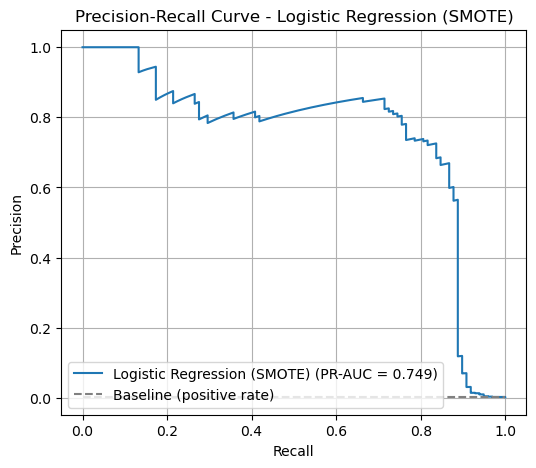


===== Random Forest (SMOTE) =====
Precision (1) : 0.7963
Recall (1)    : 0.8776
F1-score (1)  : 0.8350
PR-AUC        : 0.8628

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.80      0.88      0.83        98

    accuracy                           1.00     56962
   macro avg       0.90      0.94      0.92     56962
weighted avg       1.00      1.00      1.00     56962



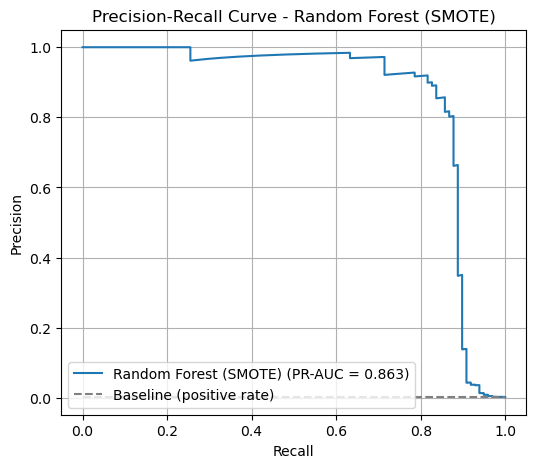


===== XGBoost (scale_pos_weight) =====
Precision (1) : 0.8632
Recall (1)    : 0.8367
F1-score (1)  : 0.8497
PR-AUC        : 0.8827

Classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56864
           1       0.86      0.84      0.85        98

    accuracy                           1.00     56962
   macro avg       0.93      0.92      0.92     56962
weighted avg       1.00      1.00      1.00     56962



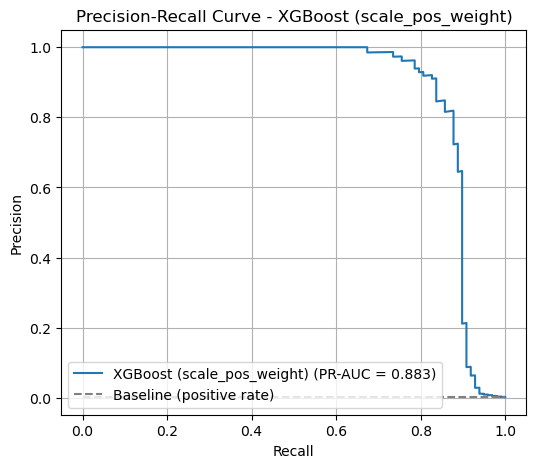

,model,precision_1,recall_1,f1_1,pr_auc
0,Logistic Regression (SMOTE),0.573333,0.877551,0.693548,0.748598
1,Random Forest (SMOTE),0.796296,0.877551,0.834951,0.862804
2,XGBoost (scale_pos_weight),0.863158,0.836735,0.849741,0.882722


In [ ]:
def evaluate_model(name, model, X_test, y_test, pos_label=1):

    # prediction (class) and probability of positive class
    y_pred  = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]

    # basic metrics
    prec  = precision_score(y_test, y_pred, pos_label=pos_label)
    rec   = recall_score(y_test, y_pred, pos_label=pos_label)
    f1    = f1_score(y_test, y_pred, pos_label=pos_label)
    prA   = average_precision_score(y_test, y_proba)  # PR-AUC

    print(f"\n===== {name} =====")
    print(f"Precision (1) : {prec:.4f}")
    print(f"Recall (1)    : {rec:.4f}")
    print(f"F1-score (1)  : {f1:.4f}")
    print(f"PR-AUC        : {prA:.4f}")
    print("\nClassification report:")
    print(classification_report(y_test, y_pred))

    # ---------- Precision-Recall curve ----------
    prec_curve, rec_curve, _ = precision_recall_curve(y_test, y_proba, pos_label=pos_label)
    plt.figure(figsize=(6,5))
    plt.plot(rec_curve, prec_curve, label=f"{name} (PR-AUC = {prA:.3f})")
    baseline = y_test.mean()  # positive rate
    plt.hlines(baseline, 0, 1, colors="gray", linestyles="--", label="Baseline (positive rate)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve - {name}")
    plt.legend()
    plt.grid(True)
    plt.show()

    # return metrics dict
    return {
        "model": name,
        "precision_1": prec,
        "recall_1": rec,
        "f1_1": f1,
        "pr_auc": prA
    }

results = []

results.append(evaluate_model("Logistic Regression (SMOTE)",    log_reg_smote, X_test, y_test))
results.append(evaluate_model("Random Forest (SMOTE)",          rfc_smote, X_test, y_test))
results.append(evaluate_model("XGBoost (scale_pos_weight)",     xgb_weighted, X_test, y_test))

results_df = pd.DataFrame(results)
results_df

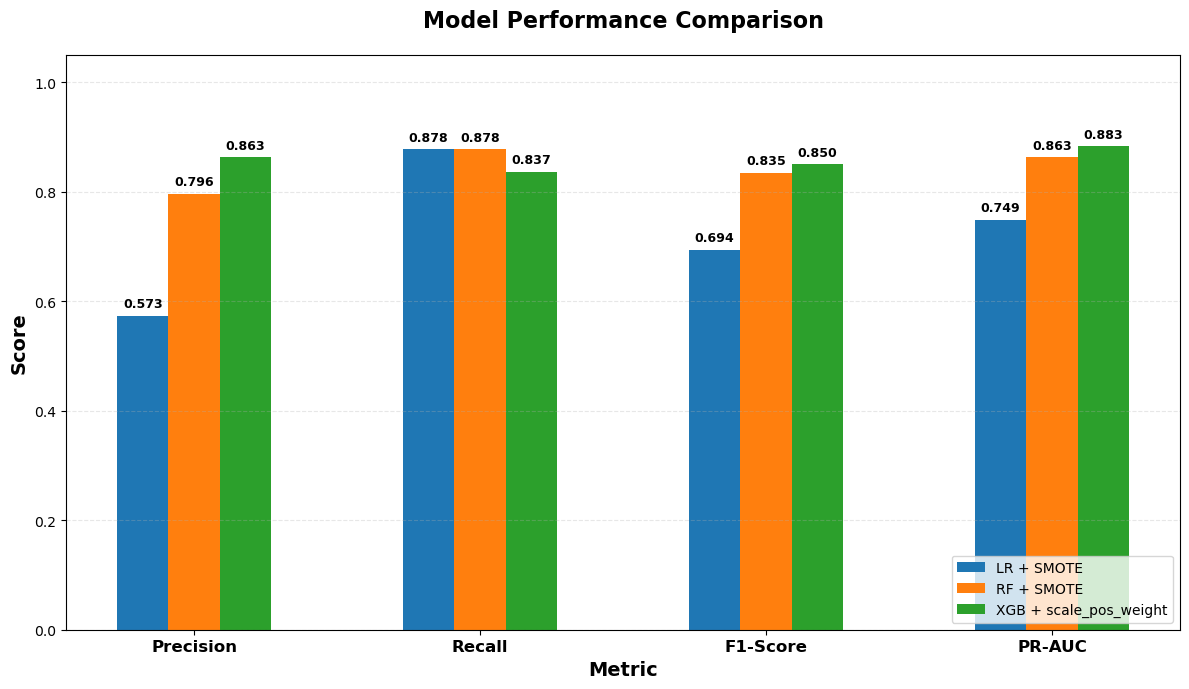

In [ ]:
lr_row     = results_df[results_df["model"] == "Logistic Regression (SMOTE)"].iloc[0]
rf_row     = results_df[results_df["model"] == "Random Forest (SMOTE)"].iloc[0]
xgb_row    = results_df[results_df["model"] == "XGBoost (scale_pos_weight)"].iloc[0]

metrics = ["Precision", "Recall", "F1-Score", "PR-AUC"]

lr_scores = [
    lr_row["precision_1"],
    lr_row["recall_1"],
    lr_row["f1_1"],
    lr_row["pr_auc"]
]

rf_scores = [
    rf_row["precision_1"],
    rf_row["recall_1"],
    rf_row["f1_1"],
    rf_row["pr_auc"]
]

xgb_scores = [
    xgb_row["precision_1"],
    xgb_row["recall_1"],
    xgb_row["f1_1"],
    xgb_row["pr_auc"]
]

# ----------------- Plot -----------------
x = np.arange(len(metrics))
width = 0.18

fig, ax = plt.subplots(figsize=(12, 7))

bars_lr      = ax.bar(x - 1*width, lr_scores,      width, label="LR + SMOTE")
bars_rf      = ax.bar(x + 0*width, rf_scores,      width, label="RF + SMOTE")
bars_xgb     = ax.bar(x + 1*width, xgb_scores,     width, label="XGB + scale_pos_weight")

def annotate_bars(bars):
    for bar in bars:
        height = bar.get_height()
        ax.text(
            bar.get_x() + bar.get_width()/2,
            height + 0.01,
            f"{height:.3f}",
            ha="center",
            va="bottom",
            fontsize=9,
            fontweight="bold"
        )

annotate_bars(bars_lr)
annotate_bars(bars_rf)
annotate_bars(bars_xgb)

ax.set_ylabel("Score", fontsize=14, fontweight="bold")
ax.set_xlabel("Metric", fontsize=14, fontweight="bold")
ax.set_title("Model Performance Comparison",
             fontsize=16, fontweight="bold", pad=20)

ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=12, fontweight="bold")
ax.legend(fontsize=10, loc="lower right")
ax.grid(True, alpha=0.3, axis="y", linestyle="--")
ax.set_ylim(0, 1.05)

plt.tight_layout()
plt.show()


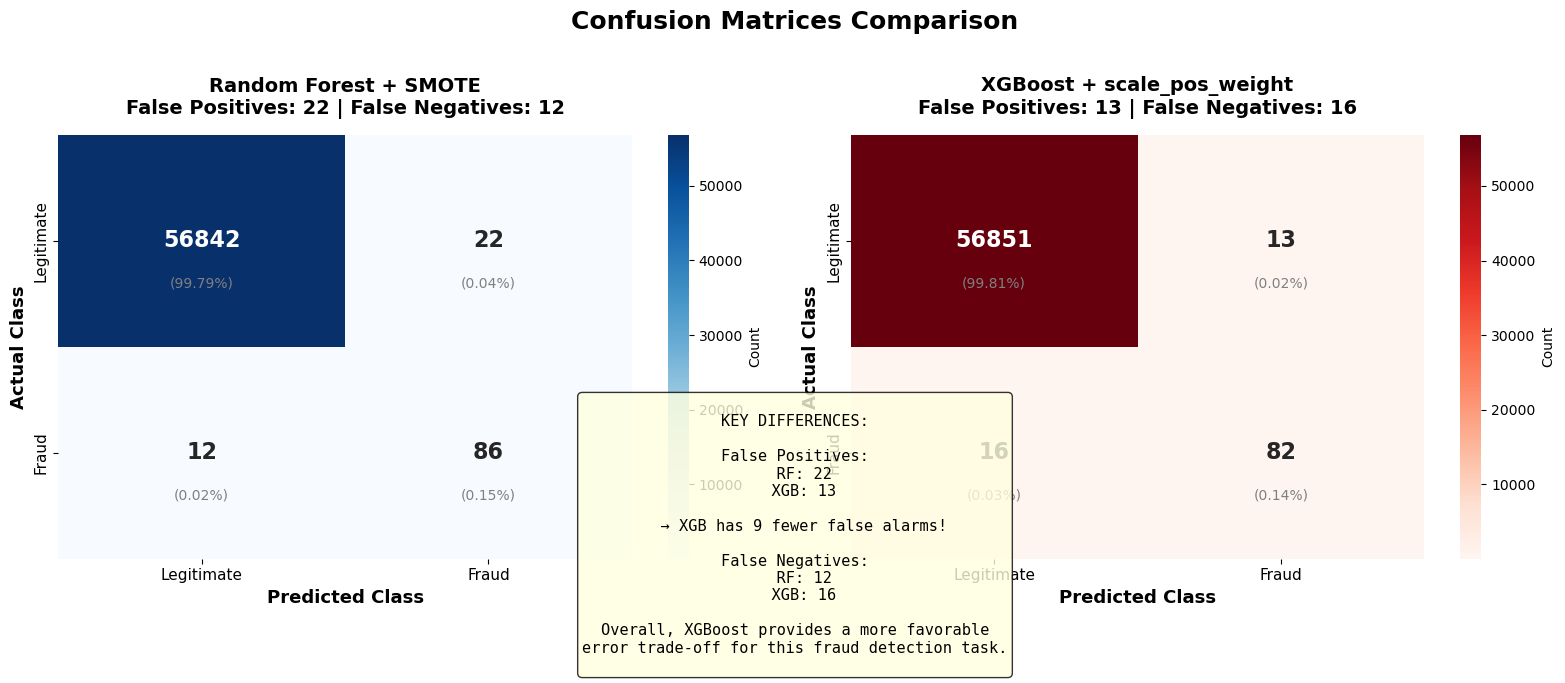

In [ ]:
#confusion matrices
lr_cm = confusion_matrix(y_test, y_pred_test_log_smote)
rf_cm = confusion_matrix(y_test, y_pred_test_rf_smote)
xgb_cm = confusion_matrix(y_test, y_pred_test_xgb_weighted)

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
fig.suptitle('Confusion Matrices Comparison', fontsize=18, fontweight='bold', y=1.02)

# Plot 1: Random Forest
sns.heatmap(rf_cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
           xticklabels=['Legitimate', 'Fraud'],
           yticklabels=['Legitimate', 'Fraud'],
           cbar_kws={'label': 'Count'},
           annot_kws={'size': 16, 'weight': 'bold'})

axes[0].set_title(f'Random Forest + SMOTE\nFalse Positives: {rf_cm[0,1]} | False Negatives: {rf_cm[1,0]}',
                 fontsize=14, fontweight='bold', pad=15)
axes[0].set_ylabel('Actual Class', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Predicted Class', fontsize=13, fontweight='bold')
axes[0].tick_params(labelsize=11)

# percentage annotations
total_rf = rf_cm.sum()
for i in range(2):
    for j in range(2):
        percentage = rf_cm[i, j] / total_rf * 100
        axes[0].text(j + 0.5, i + 0.7, f'({percentage:.2f}%)',
                    ha='center', va='center', fontsize=10, color='gray')

# Plot 2: XGBoost
sns.heatmap(xgb_cm, annot=True, fmt='d', cmap='Reds', ax=axes[1],
           xticklabels=['Legitimate', 'Fraud'],
           yticklabels=['Legitimate', 'Fraud'],
           cbar_kws={'label': 'Count'},
           annot_kws={'size': 16, 'weight': 'bold'})

axes[1].set_title(f'XGBoost + scale_pos_weight\nFalse Positives: {xgb_cm[0,1]} | False Negatives: {xgb_cm[1,0]}',
                 fontsize=14, fontweight='bold', pad=15)
axes[1].set_ylabel('Actual Class', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Predicted Class', fontsize=13, fontweight='bold')
axes[1].tick_params(labelsize=11)

#  percentage annotations
total_xgb = rf_cm.sum()
for i in range(2):
    for j in range(2):
        percentage = xgb_cm[i, j] / total_xgb * 100
        axes[1].text(j + 0.5, i + 0.7, f'({percentage:.2f}%)',
                    ha='center', va='center', fontsize=10, color='gray')

# comparison box
comparison_text = f"""
KEY DIFFERENCES:

False Positives:
  RF: {rf_cm[0,1]}
  XGB: {xgb_cm[0,1]}

  → XGB has {rf_cm[0,1] - xgb_cm[0,1]} fewer false alarms!

False Negatives:
  RF: {rf_cm[1,0]}
  XGB: {xgb_cm[1,0]}

Overall, XGBoost provides a more favorable
error trade-off for this fraud detection task.
"""

fig.text(0.5, -0.08, comparison_text, ha='center', fontsize=11,
        bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.8),
        family='monospace')

plt.tight_layout()
plt.show()

# **Section 5: Discussion**

**Model Selection Implications**

Based on both cross-validation and test set results, XGBoost with scale_pos_weight was identified as the most effective model for this credit card fraud detection task. Its strong PR-AUC performance indicates robust ranking capability under severe class imbalance, while its favorable precision–recall balance suggests practical applicability in real-world financial systems. Logistic Regression remains useful as an interpretable baseline, and Random Forest provides competitive performance; however, XGBoost offers the best overall performance when both detection effectiveness and operational cost of false alarms are considered.

**Comparison with Baseline and Alternative Models**

Although XGBoost provided the best overall performance, the baseline and alternative models still offer valuable insights.

Logistic Regression with SMOTE achieved a high recall but suffered from relatively low precision, leading to a larger number of false positives. While this behavior may be acceptable in scenarios where missing fraud is extremely costly, it may overwhelm downstream investigation teams with excessive alerts. Nevertheless, Logistic Regression remains a useful and interpretable baseline model that provides transparency and ease of explanation.

Random Forest with SMOTE delivered a more balanced performance, outperforming Logistic Regression in precision and PR-AUC while maintaining a comparable recall level. This suggests that ensemble tree-based methods are better suited for capturing non-linear relationships in the data. However, Random Forest slightly underperformed XGBoost in PR-AUC, indicating weaker ranking performance when prioritizing high-risk transactions.

Overall, while all three models demonstrated strong predictive capability, XGBoost consistently outperformed the others across the most relevant evaluation metrics.

**Limitations**

First, the dataset used in this study consists of historical credit card transactions collected over a limited time period. As fraud patterns may evolve over time, model performance could degrade when applied to future or shifting transaction behaviors. Continuous monitoring and periodic model retraining would therefore be required in real-world deployments.

Second, although PR-AUC was selected as the primary evaluation metric to address severe class imbalance, model performance was evaluated under a fixed decision threshold. In practice, threshold selection may need to be adjusted dynamically to balance fraud detection effectiveness against operational costs and customer experience.

Last, all predictive features in the dataset—except for the Time and Amount variables—were derived from Principal Component Analysis (PCA) for confidentiality reasons. While PCA helps preserve underlying variance patterns, it substantially reduces feature interpretability. As a result, understanding the direct contribution of original transactional attributes to fraud predictions is limited, which may pose challenges for explainability and regulatory requirements.

# **Section 6: Conclusion**

This project investigated the effectiveness of multiple classification models for detecting fraudulent credit card transactions under extreme class imbalance. Three approaches were evaluated: Logistic Regression with SMOTE, Random Forest with SMOTE, and XGBoost with cost-sensitive learning using scale_pos_weight.

Model performance was assessed using stratified cross-validation and evaluation metrics appropriate for imbalanced classification, with a primary focus on Precision–Recall AUC (PR-AUC), along with precision, recall, and F1-score for the fraud class. Traditional metrics such as accuracy and ROC-AUC were deprioritized due to their limited interpretability in highly imbalanced settings.

The experimental results demonstrate a clear performance hierarchy among the evaluated models. Logistic Regression with SMOTE served as a strong and interpretable baseline, achieving high recall but generating a relatively large number of false positives. Random Forest with SMOTE improved the balance between precision and recall, indicating that ensemble tree-based methods are better suited for capturing non-linear patterns in fraud data. However, XGBoost with scale_pos_weight consistently outperformed the other models, achieving the highest PR-AUC and the most favorable precision–recall trade-off.

Confusion matrix analysis further confirmed that XGBoost significantly reduced false positive predictions while maintaining a comparable level of fraud detection, making it particularly suitable for real-world fraud detection systems where operational efficiency and customer experience are critical considerations.

Overall, the findings suggest that XGBoost with cost-sensitive learning is the most effective model for this credit card fraud detection task, offering robust ranking performance under severe class imbalance while maintaining a practical balance between detection effectiveness and false alarm reduction. While interpretability remains a limitation due to the use of PCA-transformed features and ensemble learning, the observed performance gains justify its application in high-stakes financial systems. Future work may explore explainable AI techniques or hybrid cost-sensitive approaches to enhance model transparency while preserving detection performance.